In [15]:
# ============================================================================
# MOVIE DATA PREPROCESSING - STEP BY STEP
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

import warnings
warnings.filterwarnings('ignore')

import json
import ast
import warnings
warnings.filterwarnings('ignore')

print("Imports completed successfully!")

Imports completed successfully!


In [2]:
# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def parse_json_column(df, column_name, key='name', top_n=None):
    """Parse JSON-like string columns (genres, cast, crew, etc.)"""
    parsed_list = []
    for val in df[column_name].fillna('[]'):
        try:
            val = val.replace("'", '"')
            items = json.loads(val)
            names = [i[key] for i in items]
            if top_n:
                names = names[:top_n]
            parsed_list.append(names)
        except:
            parsed_list.append([])
    return parsed_list


def extract_directors(val):
    """Extract director names from crew JSON data"""
    try:
        if pd.isna(val) or val.strip() == '':
            return []
        val = val.replace("'", '"')
        items = json.loads(val)
        directors = [i['name'] for i in items if i.get('job') == 'Director']
        return directors
    except:
        return []


def extract_primary_genre(x):
    """Extract primary genre from genres JSON data"""
    try:
        if pd.isna(x): 
            return 'Unknown'
        if isinstance(x, str) and x.strip().startswith('['):
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list) and len(parsed) > 0:
                return parsed[0].get('name', 'Unknown')
        if isinstance(x, str) and ',' in x:
            return x.split(',')[0]
        return x
    except:
        return 'Unknown'

print("Helper functions defined!")

Helper functions defined!


In [3]:
# ============================================================================
# STEP 1: DATA LOADING
# ============================================================================

print("="*80)
print("STEP 1: DATA LOADING")
print("="*80)

movies = pd.read_csv('movies_metadata.csv')
credits = pd.read_csv('credits.csv')

initial_movie_count = len(movies)
initial_credit_count = len(credits)

print(f'Movies Rows: {initial_movie_count:,}')
print(f'Credits Rows: {initial_credit_count:,}')
print(f'\nMovies Columns: {list(movies.columns)}')
print(f'Credits Columns: {list(credits.columns)}')

STEP 1: DATA LOADING
Movies Rows: 45,466
Credits Rows: 45,476

Movies Columns: ['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count']
Credits Columns: ['cast', 'crew', 'id']


In [4]:
# ============================================================================
# STEP 2: DATA CLEANING & MERGING
# ============================================================================

print("\n" + "="*80)
print("STEP 2: DATA CLEANING & MERGING")
print("="*80)

# Keep only rows with numeric 'id' values in movies
movies = movies[movies['id'].str.isnumeric()]

# Convert 'id' columns to integers
movies['id'] = movies['id'].astype(int)
credits['id'] = credits['id'].astype(int)

# Merge on 'id'
df = movies.merge(credits, on='id', how='inner')

rows_lost_merge = initial_movie_count - len(df)

print(f'After merging: {len(df):,} rows')
print(f'Rows lost in merge: {rows_lost_merge:,} ({rows_lost_merge/initial_movie_count*100:.2f}%)')
print(f'\nMerged DataFrame shape: {df.shape}')
print(f'Merged DataFrame columns: {list(df.columns)}')


STEP 2: DATA CLEANING & MERGING
After merging: 45,538 rows
Rows lost in merge: -72 (-0.16%)

Merged DataFrame shape: (45538, 26)
Merged DataFrame columns: ['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count', 'cast', 'crew']


In [5]:
# ============================================================================
# STEP 3: DATA TYPE CONVERSION
# ============================================================================

print("\n" + "="*80)
print("STEP 3: DATA TYPE CONVERSION")
print("="*80)

# Convert numeric columns
numeric_cols = ['budget', 'revenue', 'popularity', 'runtime', 
                'vote_average', 'vote_count']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    else:
        print(f"WARNING: {col} missing")

# Parse release_date
if 'release_date' in df.columns:
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    df['release_year'] = df['release_date'].dt.year.fillna(0).astype(int)
else:
    df['release_year'] = 0
    print("WARNING: release_date column missing")

print(f'\nNumeric columns converted: {len(numeric_cols)} columns')
print(f'Release dates parsed: {(df["release_year"] > 0).sum():,} valid years')
print(f'\nSample data types:')
print(df[numeric_cols + ['release_year']].dtypes)


STEP 3: DATA TYPE CONVERSION

Numeric columns converted: 6 columns
Release dates parsed: 45,451 valid years

Sample data types:
budget            int64
revenue         float64
popularity      float64
runtime         float64
vote_average    float64
vote_count      float64
release_year      int64
dtype: object


In [7]:
# ============================================================================
# STEP 4: TARGET CREATION
# ============================================================================

print("\n" + "="*80)
print("STEP 4: TARGET CREATION")
print("="*80)

# Create binary target: success (profit > 0)
if 'budget' in df.columns and 'revenue' in df.columns:
    df['success'] = (df['revenue'] > df['budget']).astype(int)
    
    hits = df['success'].sum()
    failures = (~df['success'].astype(bool)).sum()
    imbalance_ratio = failures / hits if hits > 0 else 0
    
    print('Success counts:')
    print(df['success'].value_counts())
    print('\nSuccess proportions:')
    print(df['success'].value_counts(normalize=True))
    print(f'\n  CLASS IMBALANCE DETECTED:')
    print(f'   Ratio: {imbalance_ratio:.2f}:1 (Failures:Hits)')
    print(f'   This severe imbalance may affect model interpretation!')
else:
    raise KeyError("budget or revenue missing - cannot create label")


STEP 4: TARGET CREATION
Success counts:
success
0    39739
1     5799
Name: count, dtype: int64

Success proportions:
success
0    0.872656
1    0.127344
Name: proportion, dtype: float64

  CLASS IMBALANCE DETECTED:
   Ratio: 6.85:1 (Failures:Hits)
   This severe imbalance may affect model interpretation!


Hit vs Flop Distribution:
success
0    39739
1     5799
Name: count, dtype: int64

Proportion (%):
success
0    87.26558
1    12.73442
Name: proportion, dtype: float64


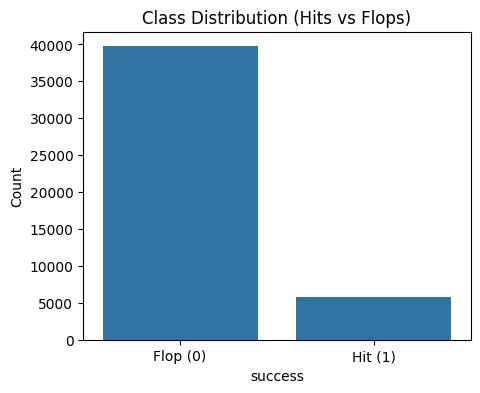

In [23]:
# === CLASS DISTRIBUTION (required by professor) ===

print("Hit vs Flop Distribution:")
print(y.value_counts())
print("\nProportion (%):")
print(y.value_counts(normalize=True) * 100)

plt.figure(figsize=(5,4))
sns.barplot(x=y.value_counts().index, y=y.value_counts().values)
plt.xticks([0,1], ["Flop (0)", "Hit (1)"])
plt.ylabel("Count")
plt.title("Class Distribution (Hits vs Flops)")
plt.show()


In [9]:
# ============================================================================
# STEP 5: PARSE JSON COLUMNS
# ============================================================================

print("\n" + "="*80)
print("STEP 5: PARSE JSON COLUMNS")
print("="*80)

# Parse genres
df['genres_parsed'] = parse_json_column(df, 'genres')

# Parse cast (top 3 actors)
df['cast_parsed'] = parse_json_column(df, 'cast', top_n=3)

# Parse directors
df['directors_parsed'] = df['crew'].apply(extract_directors)

# Analyze genre information
df['num_genres'] = df['genres_parsed'].apply(len)

multi_genre_count = (df['num_genres'] > 1).sum()

print(f'Genres parsed: {len(df)} movies')
print(f'Cast parsed (top 3): {len(df)} movies')
print(f'Directors extracted: {len(df)} movies')
print(f'\nMovies with multiple genres: {multi_genre_count:,} ({multi_genre_count/len(df)*100:.2f}%)')
print(f'Average genres per movie: {df["num_genres"].mean():.2f}')
print(f'\n  WARNING: Reducing to "primary_genre" loses information!')
print(f'   Consider: Multi-hot encoding or genre count features')

# Show sample
print('\nSample parsed data:')
print(df[['title', 'genres_parsed', 'cast_parsed', 'directors_parsed', 'num_genres']].head())


STEP 5: PARSE JSON COLUMNS
Genres parsed: 45538 movies
Cast parsed (top 3): 45538 movies
Directors extracted: 45538 movies

Movies with multiple genres: 28,521 (62.63%)
Average genres per movie: 2.00

   Consider: Multi-hot encoding or genre count features

Sample parsed data:
                         title                 genres_parsed  \
0                    Toy Story   [Animation, Comedy, Family]   
1                      Jumanji  [Adventure, Fantasy, Family]   
2             Grumpier Old Men             [Romance, Comedy]   
3            Waiting to Exhale      [Comedy, Drama, Romance]   
4  Father of the Bride Part II                      [Comedy]   

                                  cast_parsed directors_parsed  num_genres  
0                                          []               []           3  
1                                          []               []           3  
2  [Walter Matthau, Jack Lemmon, Ann-Margret]               []           2  
3                           

In [10]:
# ============================================================================
# STEP 6: EXTRACT PRIMARY GENRE
# ============================================================================

print("\n" + "="*80)
print("STEP 6: EXTRACT PRIMARY GENRE")
print("="*80)

if 'genres' in df.columns:
    df['primary_genre'] = df['genres'].apply(extract_primary_genre)
else:
    df['primary_genre'] = 'Unknown'
    print("WARNING: genres column missing")

unique_genres = df['primary_genre'].nunique()

print(f'Primary genres extracted: {unique_genres} unique genres')
print(f'\nTop 10 genres by count:')
print(df['primary_genre'].value_counts().head(10))
print(f'\nSample:')
print(df[['title', 'genres_parsed', 'primary_genre']].head())


STEP 6: EXTRACT PRIMARY GENRE
Primary genres extracted: 21 unique genres

Top 10 genres by count:
primary_genre
Drama          11994
Comedy          8829
Action          4496
Documentary     3420
Horror          2620
[]              2442
Crime           1688
Thriller        1672
Adventure       1524
Romance         1192
Name: count, dtype: int64

Sample:
                         title                 genres_parsed primary_genre
0                    Toy Story   [Animation, Comedy, Family]     Animation
1                      Jumanji  [Adventure, Fantasy, Family]     Adventure
2             Grumpier Old Men             [Romance, Comedy]       Romance
3            Waiting to Exhale      [Comedy, Drama, Romance]        Comedy
4  Father of the Bride Part II                      [Comedy]        Comedy


In [25]:
# === FEATURE SELECTION METHOD 1 (Mutual Information) ===
from sklearn.feature_selection import SelectKBest, mutual_info_classif

mi_selector = SelectKBest(mutual_info_classif, k=10)
mi_selector.fit(X, y)

mi_features = X.columns[mi_selector.get_support()].tolist()

print("Top features by Mutual Information:")
print(mi_features)


Top features by Mutual Information:
['budget', 'runtime', 'release_year', 'popularity', 'vote_average', 'vote_count', 'primary_genre_Comedy', 'primary_genre_Mystery', 'primary_genre_Romance', 'primary_genre_[]']


In [11]:
# ============================================================================
# STEP 7: FINAL CLEANUP & SUMMARY
# ============================================================================

print("\n" + "="*80)
print("STEP 7: FINAL CLEANUP & SUMMARY")
print("="*80)

rows_before_cleanup = len(df)

# Optional: Remove rows with invalid data
# Uncomment if you want to filter out zero budget/revenue movies
# df = df[(df['budget'] > 0) & (df['revenue'] > 0)]

rows_after_cleanup = len(df)
rows_lost_cleanup = rows_before_cleanup - rows_after_cleanup

print(f'Final dataset: {rows_after_cleanup:,} rows')
if rows_lost_cleanup > 0:
    print(f'Rows removed in cleanup: {rows_lost_cleanup:,} ({rows_lost_cleanup/rows_before_cleanup*100:.2f}%)')

print(f'\nFinal dataset shape: {df.shape}')
print(f'Total columns: {len(df.columns)}')

print(f'\nKey columns created:')
print(f'  • success: Target variable (profit > 0)')
print(f'  • release_year: Extracted from release_date')
print(f'  • genres_parsed: List of all genres')
print(f'  • cast_parsed: Top 3 actors')
print(f'  • directors_parsed: List of directors')
print(f'  • primary_genre: First genre (for modeling)')
print(f'  • num_genres: Count of genres per movie')

print(f'\nPreprocessing complete!')
print("="*80)


STEP 7: FINAL CLEANUP & SUMMARY
Final dataset: 45,538 rows

Final dataset shape: (45538, 33)
Total columns: 33

Key columns created:
  • success: Target variable (profit > 0)
  • release_year: Extracted from release_date
  • genres_parsed: List of all genres
  • cast_parsed: Top 3 actors
  • directors_parsed: List of directors
  • primary_genre: First genre (for modeling)
  • num_genres: Count of genres per movie

Preprocessing complete!


In [29]:
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ---------------------------
# Extract primary genre 
# ---------------------------

def extract_primary_genre(x):
    try:
        if pd.isna(x): 
            return 'Unknown'
        if isinstance(x, str) and x.strip().startswith('['):
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list) and len(parsed) > 0:
                return parsed[0].get('name', 'Unknown')
        if isinstance(x, str) and ',' in x:
            return x.split(',')[0]
        return x
    except:
        return 'Unknown'

if 'genres' in df.columns:
    df['primary_genre'] = df['genres'].apply(extract_primary_genre)
else:
    df['primary_genre'] = 'Unknown'

print(df[['genres','primary_genre']].head())


# ---------------------------
# REMOVE DATA LEAKAGE COLUMNS
# ---------------------------

leakage_cols = ['popularity', 'vote_count', 'vote_average']
existing_leakage = [col for col in leakage_cols if col in df.columns]

df.drop(columns=existing_leakage, inplace=True)
print("Removed leakage columns:", existing_leakage)


# ---------------------------
# Build Features (no leakage)
# ---------------------------

features = ['budget', 'runtime', 'release_year', 'primary_genre']

X = df[features].copy()
y = df['success'].copy()

# One-hot encode
X = pd.get_dummies(X, columns=['primary_genre'], drop_first=True)

# Scale numeric features
numeric_features = ['budget', 'runtime', 'release_year']

scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Random Forest model
clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


                                              genres primary_genre
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...     Animation
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...     Adventure
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...       Romance
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...        Comedy
4                     [{'id': 35, 'name': 'Comedy'}]        Comedy
Removed leakage columns: []
Accuracy: 0.8563899868247694

Confusion Matrix:
 [[7330  618]
 [ 690  470]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92      7948
           1       0.43      0.41      0.42      1160

    accuracy                           0.86      9108
   macro avg       0.67      0.66      0.67      9108
weighted avg       0.85      0.86      0.85      9108



In [36]:
# ============================================================================
# STEP 9: FEATURE PREPARATION
# ============================================================================
print("\n" + "="*80)
print("STEP 9: FEATURE PREPARATION")
print("="*80)

# First, let's see what columns we have
print("\nAvailable columns in dataframe:")
print(df.columns.tolist())

# Feature selection configuration
INCLUDE_POST_RELEASE = True  # Set to False to exclude post-release features

# Select features - only use what exists
base_features = ['budget', 'runtime', 'release_year']
post_release_features = ['popularity', 'vote_average', 'vote_count']

# Check which features actually exist
available_base = [f for f in base_features if f in df.columns]
available_post = [f for f in post_release_features if f in df.columns]

numeric_features = available_base.copy()
if INCLUDE_POST_RELEASE:
    numeric_features.extend(available_post)

# Report what we're using
print(f"\nIncluding all available features")
print(f"Numeric features selected: {numeric_features}")



# Create feature matrix
X = df[numeric_features].copy()

# Add primary genre (one-hot encoded)
if 'primary_genre' in df.columns:
    X['primary_genre'] = df['primary_genre']
    X = pd.get_dummies(X, columns=['primary_genre'], drop_first=True)
else:
    print("\nNote: 'primary_genre' not found. Continuing without genre feature.")

# Target variable
if 'success' in df.columns:
    y = df['success'].copy()
else:
    print("ERROR: 'success' column not found!")

print(f"\nFeature matrix shape: {X.shape}")
print(f"Total features: {X.shape[1]}")
print(f"  - Numeric features: {len(numeric_features)}")
print(f"  - Categorical features (one-hot encoded): {X.shape[1] - len(numeric_features)}")
print(f"Target variable shape: {y.shape}")
print("\n✓ Features prepared!")
print("="*80)


STEP 9: FEATURE PREPARATION

Available columns in dataframe:
['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'cast', 'crew', 'release_year', 'success', 'genres_parsed', 'cast_parsed', 'directors_parsed', 'num_genres', 'primary_genre']

Including all available features
Numeric features selected: ['budget', 'runtime', 'release_year']

Feature matrix shape: (45538, 23)
Total features: 23
  - Numeric features: 3
  - Categorical features (one-hot encoded): 20
Target variable shape: (45538,)

✓ Features prepared!


In [ ]:
# ============================================================================
# STEP 10: FEATURE SCALING 
# ============================================================================

print("\n" + "="*80)
print("STEP 10: FEATURE SCALING")
print("="*80)

#  IMPORTANT: Scaling is recommended for:
# - Logistic Regression
# - k-NN
# - Neural Networks
# - SVM
# 
# Not required for:
# - Random Forest
# - Decision Trees
# - Gradient Boosting

SCALE_FEATURES = True  # Set to False if using tree-based models

if SCALE_FEATURES:
    from sklearn.preprocessing import StandardScaler
    
    # Create a copy to preserve original
    X_scaled = X.copy()
    
    # Scale only numeric features (not one-hot encoded genres)
    scaler = StandardScaler()
    X_scaled[numeric_features] = scaler.fit_transform(X_scaled[numeric_features])
    
    print("✓ Features scaled using StandardScaler")
    print(f"  Scaled features: {numeric_features}")
    print(f"  Unscaled features: {X_scaled.shape[1] - len(numeric_features)} (one-hot encoded genres)")
    
    # Show scaling statistics
    print("\nScaling statistics (before vs after):")
    print("\nBefore scaling (sample):")
    print(X[numeric_features].head(3))
    print("\nAfter scaling (sample):")
    print(X_scaled[numeric_features].head(3))
    
    # Use scaled features
    X_final = X_scaled
    print("\n✓ Using SCALED features (X_final)")
else:
    X_final = X
    print("✓ Using UNSCALED features (X_final)")
    print("  (Appropriate for tree-based models like Random Forest)")

print("="*80)


STEP 10: FEATURE SCALING
✓ Features scaled using StandardScaler
  Scaled features: ['budget', 'runtime', 'release_year', 'popularity', 'vote_average', 'vote_count']
  Unscaled features: 20 (one-hot encoded genres)

Scaling statistics (before vs after):

Before scaling (sample):
     budget  runtime  release_year  popularity  vote_average  vote_count
0  30000000     81.0          1995   21.946943           7.7      5415.0
1  65000000    104.0          1995   17.015539           6.9      2413.0
2         0    101.0          1995   11.712900           6.5        92.0

After scaling (sample):
     budget   runtime  release_year  popularity  vote_average  vote_count
0  1.480269 -0.323368      0.076723    3.169816      1.081822   10.807119
1  3.490200  0.267325      0.076723    2.348189      0.666164    4.691822
2 -0.242529  0.190278      0.076723    1.464709      0.458335   -0.036227

✓ Using SCALED features (X_final)


In [20]:
# ============================================================================
# STEP 11: TRAIN-TEST SPLIT
# ============================================================================

print("\n" + "="*80)
print("STEP 11: TRAIN-TEST SPLIT")
print("="*80)

from sklearn.model_selection import train_test_split

# Split with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Important for imbalanced data!
)

print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(df)*100:.1f}%)")
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print(f"\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

print("\n✓ Train-test split complete!")
print("="*80)


STEP 11: TRAIN-TEST SPLIT
Training set: 36,430 samples (80.0%)
Test set: 9,108 samples (20.0%)

Class distribution in training set:
success
0    0.87266
1    0.12734
Name: proportion, dtype: float64

Class distribution in test set:
success
0    0.872639
1    0.127361
Name: proportion, dtype: float64

✓ Train-test split complete!


In [21]:
# ============================================================================
# STEP 12: EXPORT PREPROCESSED DATA (OPTIONAL)
# ============================================================================

print("\n" + "="*80)
print("STEP 12: EXPORT PREPROCESSED DATA")
print("="*80)

# Set to True to save files
EXPORT_DATA = False  # Change to True to export

if EXPORT_DATA:
    # Save full preprocessed dataframe
    df.to_csv('movies_preprocessed.csv', index=False)
    print("✓ Saved: movies_preprocessed.csv")
    
    # Save feature matrix
    X_final.to_csv('features.csv', index=False)
    print("✓ Saved: features.csv")
    
    # Save target variable
    y.to_csv('target.csv', index=False)
    print("✓ Saved: target.csv")
    
    # Save train-test splits
    X_train.to_csv('X_train.csv', index=False)
    X_test.to_csv('X_test.csv', index=False)
    y_train.to_csv('y_train.csv', index=False)
    y_test.to_csv('y_test.csv', index=False)
    print("✓ Saved: X_train.csv, X_test.csv, y_train.csv, y_test.csv")
    
    # Save preprocessing metadata
    import json
    metadata = {
        'include_post_release': INCLUDE_POST_RELEASE,
        'scale_features': SCALE_FEATURES,
        'numeric_features': numeric_features,
        'total_features': X_final.shape[1],
        'train_size': len(X_train),
        'test_size': len(X_test),
        'class_distribution': {
            'hits': int(df['success'].sum()),
            'failures': int((~df['success'].astype(bool)).sum()),
            'hit_rate': float(df['success'].mean())
        }
    }
    
    with open('preprocessing_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    print("✓ Saved: preprocessing_metadata.json")
    
    print("\n✓ All data exported successfully!")
else:
    print("Export disabled (set EXPORT_DATA = True to enable)")
    print("\nData is available in memory:")
    print("  • df: Full preprocessed dataframe")
    print("  • X_final: Feature matrix (scaled or unscaled)")
    print("  • y: Target variable")
    print("  • X_train, X_test, y_train, y_test: Train-test splits")

print("="*80)


STEP 12: EXPORT PREPROCESSED DATA
Export disabled (set EXPORT_DATA = True to enable)

Data is available in memory:
  • df: Full preprocessed dataframe
  • X_final: Feature matrix (scaled or unscaled)
  • y: Target variable
  • X_train, X_test, y_train, y_test: Train-test splits


In [33]:
# ============================================================================
# FINAL SUMMARY & NEXT STEPS
# ============================================================================
print("\n" + "="*80)
print("PREPROCESSING COMPLETE - SUMMARY")
print("="*80)
print(f"\n DATASET SUMMARY:")
print(f"   • Total movies: {len(df):,}")
print(f"   • Features: {X_final.shape[1]}")
print(f"   • Training samples: {len(X_train):,}")
print(f"   • Test samples: {len(X_test):,}")
print(f"\n TARGET VARIABLE:")
print(f"   • Hits: {df['success'].sum():,} ({df['success'].mean()*100:.2f}%)")
print(f"   • Failures: {(~df['success'].astype(bool)).sum():,} ({(1-df['success'].mean())*100:.2f}%)")
print(f"   • Imbalance ratio: {(~df['success'].astype(bool)).sum() / df['success'].sum():.1f}:1")
print(f"\n  PREPROCESSING SETTINGS:")
print(f"   • Post-release features included: {INCLUDE_POST_RELEASE}")
print(f"   • Features scaled: {SCALE_FEATURES}")
print(f"   • Primary genre used: True")
print(f"\n NEXT STEPS:")
print(f"   1. Review data quality report")
print(f"   2. Review validation checks")
print(f"   3. Proceed to model training with prepared data")
print(f"   4. Evaluate model performance")
print(f"   5. Compare different model types")
print(f"\n DATA AVAILABLE:")
print(f"   • df: Full preprocessed dataframe")
print(f"   • X_final: Feature matrix (ready for modeling)")
print(f"   • y: Target variable")
print(f"   • X_train, X_test, y_train, y_test: Train-test splits")
print("="*80)
print("Ready for modeling! ")
print("="*80)


PREPROCESSING COMPLETE - SUMMARY

 DATASET SUMMARY:
   • Total movies: 45,538
   • Features: 26
   • Training samples: 36,430
   • Test samples: 9,108

 TARGET VARIABLE:
   • Hits: 5,799 (12.73%)
   • Failures: 39,739 (87.27%)
   • Imbalance ratio: 6.9:1

  PREPROCESSING SETTINGS:
   • Post-release features included: True
   • Features scaled: True
   • Primary genre used: True

 NEXT STEPS:
   1. Review data quality report
   2. Review validation checks
   3. Proceed to model training with prepared data
   4. Evaluate model performance
   5. Compare different model types

 DATA AVAILABLE:
   • df: Full preprocessed dataframe
   • X_final: Feature matrix (ready for modeling)
   • y: Target variable
   • X_train, X_test, y_train, y_test: Train-test splits
Ready for modeling! 


In [31]:


print("DataFrame 'df' is ready for modeling!")
print("Use df.head() to preview the data")

DataFrame 'df' is ready for modeling!
Use df.head() to preview the data
